In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import csv
import seaborn as sns
import corner
from pathlib import Path

In [3]:
def cumul_avg(tab):
    """Given a list of computable values (int/float)
    computes the corresponding list of moving average
    (cumulative average)

    Arguments:
        tab {List[int]} -- List of observed values

    Returns:
        {List[int]} -- Corresponding list of moving average
    """

    res = list()
    res = np.cumsum(tab) / np.arange(1, len(tab) + 1)
    #for i in range(1, len(tab)):
    #    cum_avg = sum(tab[0:i]) / (i + 1)
    #    res.append(cum_avg)

    return res


def cdf(data):
    """ CDF : Cumulative Distribution function
    Returns the Cumulative Distribution of the dataset (data)

    Arguments:
        data {List[float]} -- dataset

    Returns:
        {List[foat], List[float]} -- absciss, ordinate
    """

    x = np.sort(data)
    y = np.arange(1, len(data) + 1) / len(data)
    return x, y


def display(dataset,  prefix=""):
    """Creates a fil displaying a summary of the model

    Arguments:
        results {List[GraphWrapper)] -- instance of the graph
                                        for each iteration
        summary_fct {fonction} -- function returning a summary dict
        title {str} -- Figure's title

    Keyword Arguments:
        prefix {str} -- filen (default: {""})
    """
    """
    Displays five different charts

    Arguments:
        results {[type]} - - [description]

    Keyword Arguments:
        prefix {str} - - [description](default: {""})
    """

    fig = plt.figure(figsize=(10, 10))

    for idx, label in enumerate(dataset):
        ax = plt.subplot(len(dataset), 1, idx + 1)
        ax.plot(dataset[label], label='Sample value')
        ax.plot(cumul_avg(dataset[label]), label='Cumulative average')
        ax.set_ylabel(label)

    plt.legend()
    plt.xlabel("Iterations")

    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('Metropolis hasting algorithm : Markov model')

    fig.savefig(prefix + "chain.pdf")


def dist_display(dataset, prefix=""):
    """Displays the samples’ distribution.

    Arguments:
        results {List[GraphWrapper]} -- List of resulting graph
                                        for each iteration

        summary_fct {fonction} -- function returning a summary dict

    Keyword Arguments:
        prefix {str} -- filename prefix (default: {""})
    """

    fig = plt.figure(figsize=(20, 20))
    fig.suptitle('Distribution Summary', fontsize=30)
    # Creates a grid with as many rows as entries in dataset and 2 columns
    # The first column is dedicated to the histogramme
    # The second one is dedicated to the CDF
    grid = plt.GridSpec(len(dataset), 3, hspace=0.6)

    for idx, label in enumerate(dataset):
        # Iterates over each grid's line
        hist_area = fig.add_subplot(grid[idx, 0])
        cdf_area = fig.add_subplot(grid[idx, 1])
        qq_plot_area = fig.add_subplot(grid[idx, 2])

        hist_area.set_title('{} Distribution'.format(label))
        hist_area.set_xlabel('Observed value')
        hist_area.set_ylabel('Distribution density')
        hist_area.hist(dataset[label], bins=50)

        cdf_area.set_title('{}\' CDF'.format(label))
        cdf_area.set_xlabel('Observed value')
        cdf_area.set_ylabel('Density')
        cdf_x, cdf_y = cdf(dataset[label])
        cdf_area.plot(cdf_x, cdf_y)

        stats.probplot(dataset[label], dist="norm", plot=qq_plot_area)
        qq_plot_area.set_title("Potts Q-Q plot for {}".format(label))
        qq_plot_area.get_lines()[0].set_markerfacecolor('C0')
        qq_plot_area.get_lines()[1].set_color('C2')

    fig.savefig(prefix + "dist.pdf")

def read_raw_traces(path):
    with open(path, 'r') as file:
        reader = csv.reader(file)
        raw_data = list()
        try:
            for row in reader:
                raw_data.append([float(r) for r in row])
        except ValueError:
            print("error", row)
    data_trans = np.array(raw_data).transpose()
    return data_trans

def extract_posterior_dist(path, burn_in=0, by=1):
    data_trans = read_raw_traces(path)
    data_frame = pd.DataFrame({r'$\theta_{11}$': [b for b in data_trans[0][burn_in::by]],
                               r'$\theta_{12}$': [b for b in data_trans[1][burn_in::by]],
                               r'$\theta_{22}$': [b for b in data_trans[2][burn_in::by]]})
    return data_frame

def extract_sim_traces(path):
    data_trans = read_raw_traces(path)
    data = dict()
    data[r"$t_{01}(y)$"] = data_trans[0][1:]
    data[r"$t_{02}(y)$"] = data_trans[1][1:]
    data[r"$t_{12}(y)$"] = data_trans[2][1:]
    return data

def plot_marginals(data_abc, perfect_vals, burn_in=0, by=1):
    
    col_names = data_abc.columns.values
    
    fig, axs = plt.subplots(len(col_names), 2, figsize=(14,25))
    
    for idx, param_name in np.ndenumerate(col_names):
        i = idx[0]
        # Sample parameter
        params = data_abc[param_name].tolist()[burn_in::by]

        # Distribution
        sns.distplot(params, axlabel="{} distribution ABC".format(param_name), ax=axs[i, 0])
        axs[i, 0].axvline(perfect_vals[i], color='r', linestyle='--', label='expected value')

        # Path
        axs[i, 1].plot(range(len(params)), params)
        axs[i, 1].axhline(perfect_vals[i], color='r', linestyle='--', label='expected value')
        axs[i, 1].set(xlabel='iterations', ylabel='{} parameter ABC'.format(param_name))

def print_config(path) :
    with open(path) as f:
        lines = f.readlines()
    for l in lines:
        if not l.startswith("#") and len(l):
            print(l.rstrip())

def MAP_computation(data_abc, burn_in=0, by=1):
    col_names = data_abc.columns.values
    map_vec = list()
    for idx, col_name in np.ndenumerate(col_names):
        i = idx[0]
        p=sns.kdeplot(data_abc[col_name][burn_in::by], shade=True)
        x = p.lines[i].get_xdata()
        y = p.lines[i].get_ydata()
        max_theta = np.around(x[np.argmax(y)], decimals=4)
        map_vec.append(max_theta)
    return map_vec

def corner_plot(data_post, map_theta, truths, output_path, print_truths=True, burn_in=0, by=1):
    data = data_post[burn_in::by]
    fig = corner.corner(data.values, quantiles=(0.25, 0.50, 0.75), bins=30, labels=[r"$\theta_{11}$", r"$\theta_{12}$", r"$\theta_{22}$"], truths=map_theta, show_titles=True, title_kwargs={"fontsize": 12})
    axes = np.array(fig.axes).reshape((3, 3))
    if print_truths:
        for i in range(3):
            ax = axes[i, i]
            ax.axvline(truths[i], color="g")

        for yi in range(3):
            for xi in range(yi):
                ax = axes[yi, xi]
                ax.axvline(truths[xi], color="g")
                ax.axhline(truths[yi], color="g")
                ax.plot(truths[xi], truths[yi], "sg")
    plt.savefig(output_path)
    
def summary(data, burnin=0, by=1):
    col_names = data.columns.values
    for i in [10,25,50,75,95]:
        print("========== Q{} ==========".format(i))
        for _, param_name in np.ndenumerate(col_names):
            q = np.around(np.percentile(data[param_name][burnin::by], i), decimals=3)
            print("Q{} for {} parameter {}".format(i, param_name, q))
    print("========== mean ==========")
    for _, param_name in np.ndenumerate(col_names):
        mean = np.around(np.mean(data[param_name]), decimals=3)
        print("mean for {} parameter {}".format(param_name, mean))


In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
error.stat.area = function(name.file,data.est){
    # ... reading the file of sufficient statistics
    data.area = read.table(name.file,sep = ",", header=F)

    # ... burning-in : drop-on the first values,
    # if exact simulation is used there is no need for burning-in ...
    pos=seq(from=1,nrow(data.area),1)

    nsamples=length(pos);

    beta1=data.area[pos,1]
    beta2=data.area[pos,2]
    beta3=data.area[pos,3]
    
    mnbeta1=cumsum(beta1)/(1:nsamples)
    mnbeta2=cumsum(beta2)/(1:nsamples)
    mnbeta3=cumsum(beta3)/(1:nsamples)

    esp.stat=c(mean(beta1),mean(beta2), mean(beta3))
    #print(esp.stat)
    grad=data.est[1:3]-esp.stat
    mat1=matrix(esp.stat,nrow=3,ncol=1)
    mat2=mat1%*%t(mat1)
    #print(mat2)
    mat3=matrix(0,nrow=3,ncol=3)

    for(i in 1 : nsamples)
    {
        stat.temp = c(beta1[i],beta2[i], beta3[i])
        temp=matrix(stat.temp,nrow=3,ncol=1)
        mat.temp=temp%*%t(temp)
        mat3=mat3+mat.temp
    }
    mat3=(1/nsamples)*mat3
    #print(mat3)
    hess=-(mat3-mat2)
    b1=solve(-hess)

   
   
    z1=data.est[1]-beta1
    z2=data.est[2]-beta2
    z3=data.est[3]-beta3
    z4=c(cor(z1,z1),cor(z1,z2),cor(z1,z3),cor(z2,z1),cor(z2,z2),cor(z2,z3),cor(z3,z1),cor(z3,z2),cor(z3,z3))
    a1=matrix(z4,nrow=3,ncol=3)
    c1=(1/sqrt(nsamples))*b1%*%a1%*%b1

    list(gradient=grad,hessien=hess,B1=b1,C1=c1)
}

In [6]:
OUTPUT_DIR = "./outputs/figures/journal_paper/setup"
output_path = Path(OUTPUT_DIR)
BY = 100
BURNIN = 2000

In [ ]:
posterior_geo = extract_posterior_dist("./assets/setup/n200/paper_theta0_traces.csv")

In [ ]:
print_config("./assets/setup/simulated_data/paper_theta0_config.txt")

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


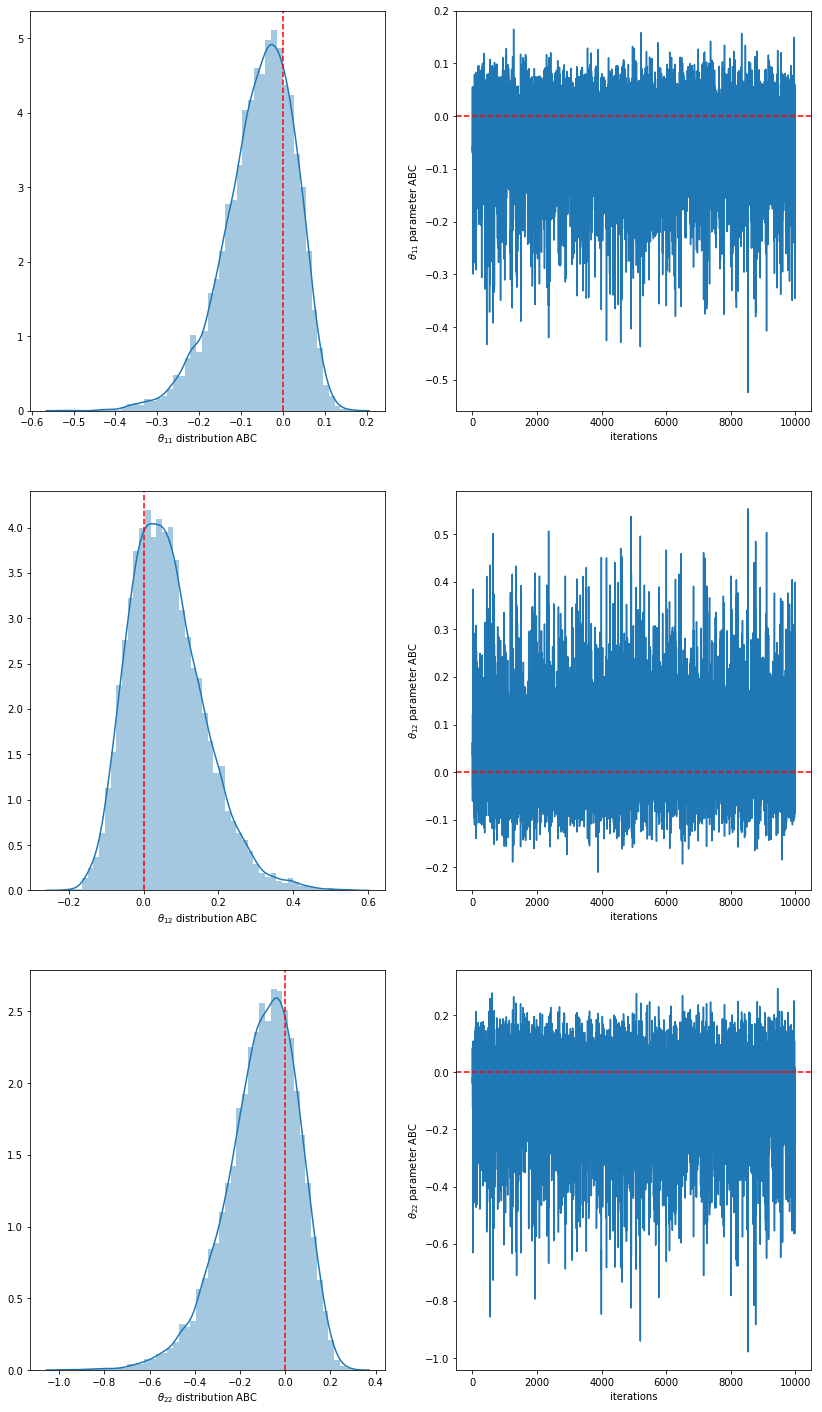

In [26]:
truths = [0, 0, 0]
plot_marginals(posterior_geo, truths, burn_in=BURNIN, by=BY)

[-0.0246, 0.0187, -0.0333]

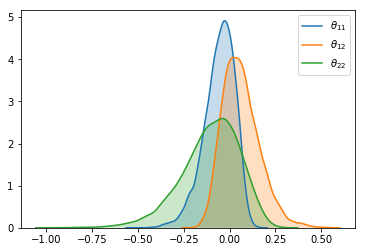

In [28]:
map_theta = MAP_computation(posterior_geo, burn_in=BURNIN, by=BY)
map_theta

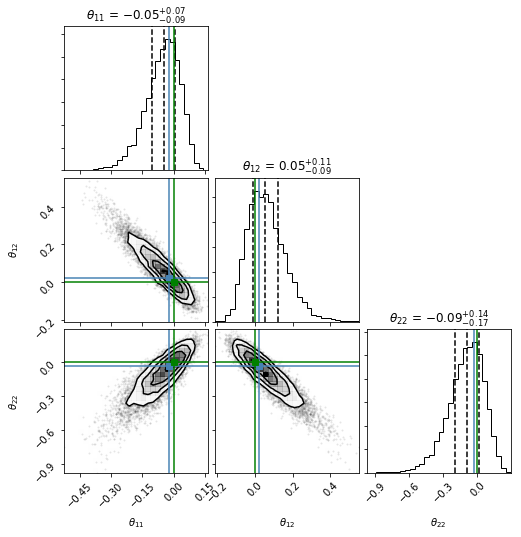

In [29]:
corner_plot(posterior_geo, map_theta, truths, output_path / "geo_verif.pdf", burn_in=BURNIN, by=BY)

In [26]:
summary(posterior_geo, by=BY, burnin=BURNIN)

========== Q10 ==========
Q10 for $\theta_{01}$ parameter -0.166
Q10 for $\theta_{02}$ parameter -0.056
Q10 for $\theta_{12}$ parameter -0.316
========== Q25 ==========
Q25 for $\theta_{01}$ parameter -0.105
Q25 for $\theta_{02}$ parameter -0.011
Q25 for $\theta_{12}$ parameter -0.198
========== Q50 ==========
Q50 for $\theta_{01}$ parameter -0.046
Q50 for $\theta_{02}$ parameter 0.05
Q50 for $\theta_{12}$ parameter -0.087
========== Q75 ==========
Q75 for $\theta_{01}$ parameter 0.005
Q75 for $\theta_{02}$ parameter 0.123
Q75 for $\theta_{12}$ parameter 0.009
========== Q95 ==========
Q95 for $\theta_{01}$ parameter 0.063
Q95 for $\theta_{02}$ parameter 0.246
Q95 for $\theta_{12}$ parameter 0.123
========== mean ==========
mean for $\theta_{01}$ parameter -0.055
mean for $\theta_{02}$ parameter 0.062
mean for $\theta_{12}$ parameter -0.103


In [47]:
%%R -o var
res = error.stat.area("./assets/setup/n200/sim_post/potts-geo_traces.csv", c(164.747,263.495,83.7645))
print(diag(res$grad))
print(sqrt(diag(res$B1)))
print(diag(res$C1))
var = c(sqrt(diag(res$B1)), diag(res$C1))

        [,1]    [,2]   [,3]
[1,] 14.2559  0.0000 0.0000
[2,]  0.0000 11.8663 0.0000
[3,]  0.0000  0.0000 1.8649
[1] 0.07968329 0.09263077 0.14406154
[1] 3.843063e-07 5.757111e-07 1.981360e-06


In [49]:
b1 = np.around(np.array(var[0:3]), decimals=3)
c1 = np.around(np.array(var[3:6]), decimals=8)
print(b1)
print(c1)

[0.08  0.093 0.144]
[3.80e-07 5.80e-07 1.98e-06]


In [ ]:
posterior_fixed = extract_posterior_dist("./assets/setup/simulated_data/theta_fixed_traces.csv")

In [31]:
print_config("./assets/setup/n200/theta_fixed_config.txt")

size: 12,8
theta_0: 0,0,0
delta: 0.01,0.01,0.01
seed: 2019
iter: 1002000
n: 200
sampler_it: 500
y_obs: 79.1769,361.796,296.235
theta_perf: -0.5,0.2,0.3
obs_sim: 0
duration: 26187.1


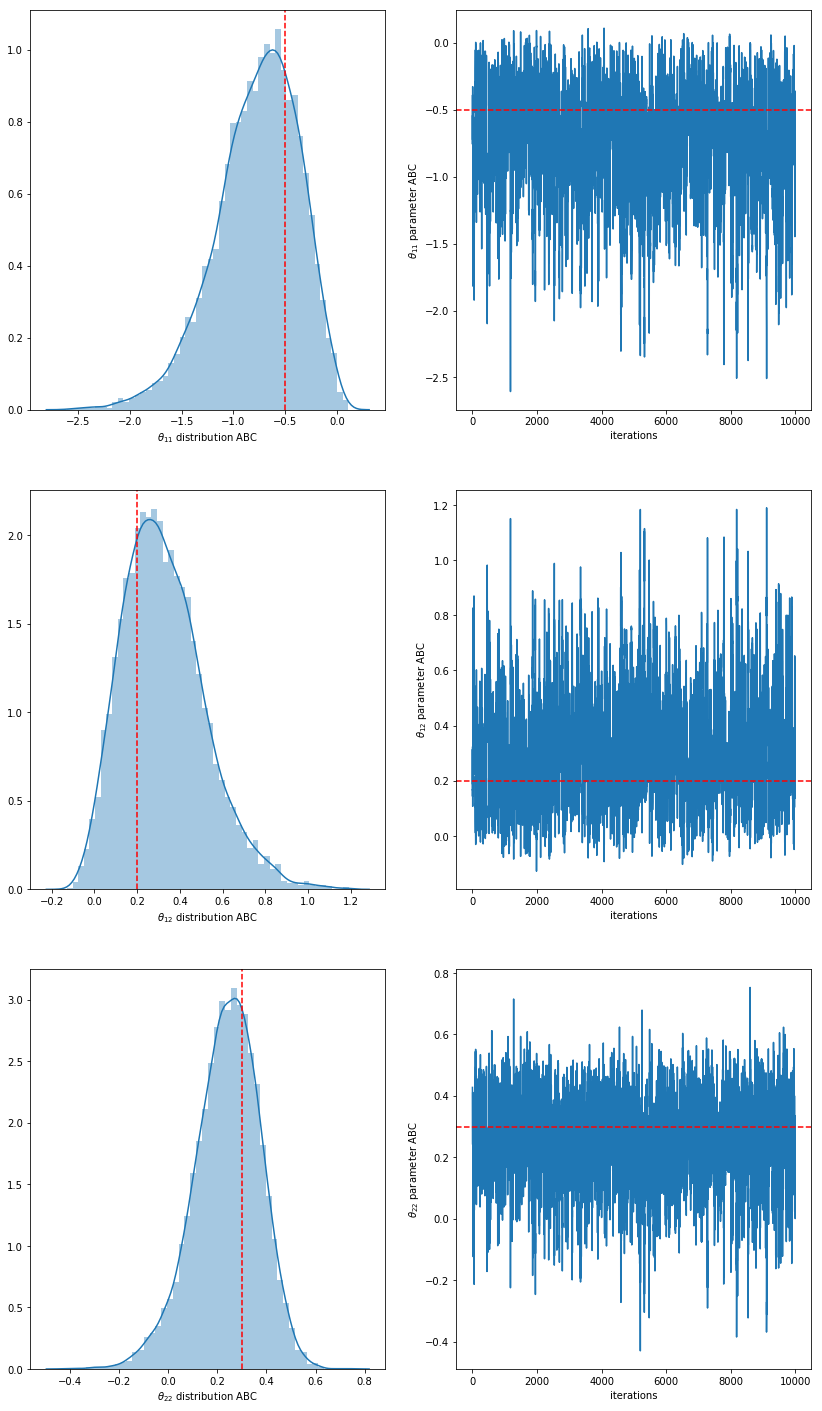

In [32]:
truths_fixed = [-0.5, 0.2, 0.3]
plot_marginals(posterior_fixed, truths_fixed, burn_in=BURNIN, by=BY)

[-0.6228, 0.263, 0.2698]

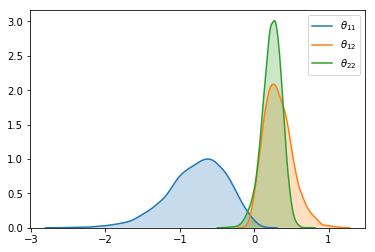

In [33]:
map_theta_fixed = MAP_computation(posterior_fixed, burn_in=BURNIN, by=BY)
map_theta_fixed

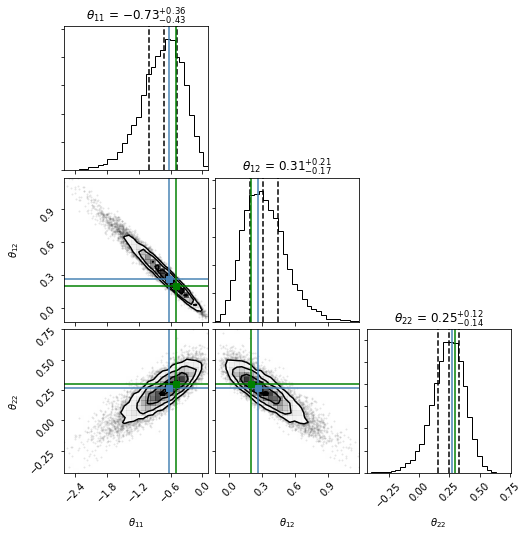

In [34]:
corner_plot(posterior_fixed, map_theta_fixed, truths_fixed, output_path / "potts_verif.pdf", by=BY, burn_in=BURNIN)

In [25]:
summary(posterior_fixed, by=BY, burnin=BURNIN)

========== Q10 ==========
Q10 for $\theta_{01}$ parameter -1.302
Q10 for $\theta_{02}$ parameter 0.093
Q10 for $\theta_{12}$ parameter 0.066
========== Q25 ==========
Q25 for $\theta_{01}$ parameter -1.014
Q25 for $\theta_{02}$ parameter 0.185
Q25 for $\theta_{12}$ parameter 0.156
========== Q50 ==========
Q50 for $\theta_{01}$ parameter -0.728
Q50 for $\theta_{02}$ parameter 0.307
Q50 for $\theta_{12}$ parameter 0.247
========== Q75 ==========
Q75 for $\theta_{01}$ parameter -0.472
Q75 for $\theta_{02}$ parameter 0.443
Q75 for $\theta_{12}$ parameter 0.332
========== Q95 ==========
Q95 for $\theta_{01}$ parameter -0.188
Q95 for $\theta_{02}$ parameter 0.673
Q95 for $\theta_{12}$ parameter 0.442
========== mean ==========
mean for $\theta_{01}$ parameter -0.769
mean for $\theta_{02}$ parameter 0.325
mean for $\theta_{12}$ parameter 0.24


In [24]:
%%R -o var
res = error.stat.area("./assets/setup/n200/sim_post/potts-fixed_traces.csv", c(79.1769,361.796,296.235))
print(diag(res$grad))
print(sqrt(diag(res$B1)))
print(diag(res$C1))
var = c(sqrt(diag(res$B1)), diag(res$C1))

       [,1]    [,2]    [,3]
[1,] -1.905  0.0000  0.0000
[2,]  0.000 -7.5063  0.0000
[3,]  0.000  0.0000 -2.5584
[1] 0.3977996 0.1910142 0.1309673
[1] 9.893319e-05 2.151383e-05 8.406650e-06


In [48]:
b1 = np.around(np.array(var[0:3]), decimals=3)
c1 = np.around(np.array(var[3:6]), decimals=8)
print(b1)
print(c1)

[0.08  0.093 0.144]
[3.80e-07 5.80e-07 1.98e-06]
